In [3]:
from dataset import *
from model import *
from train import *
from inference import *

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-12-15 21:14:34.265717: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-12-15 21:14:35.020675: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat

## Dataset.py

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-12-15 21:14:35.754230: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


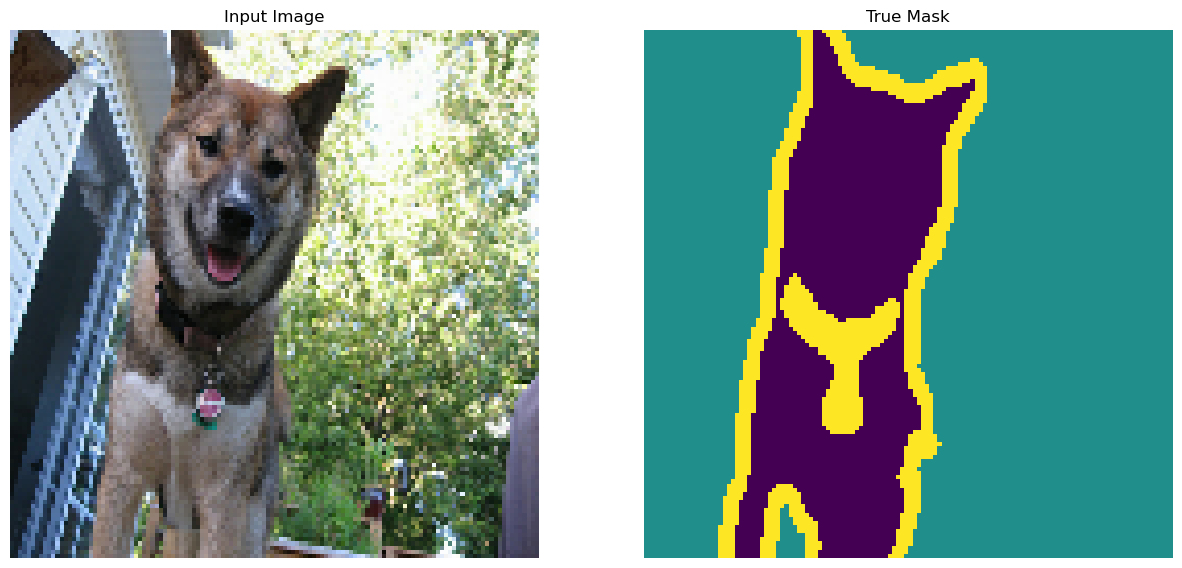

In [4]:
train_batches, test_batches, info, sample_image, sample_mask = get_dataset()
display([sample_image, sample_mask])

## Model.py


In [5]:
output_classes = 3

model = unet_model(output_channels=output_classes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [1]:
# tf.keras.utils.plot_model(model, show_shapes=True)
from IPython.display import Image, display
display(Image(url='model_architecture.png'))

## Train.py

1/1 [==============================] - 0s 401ms/step


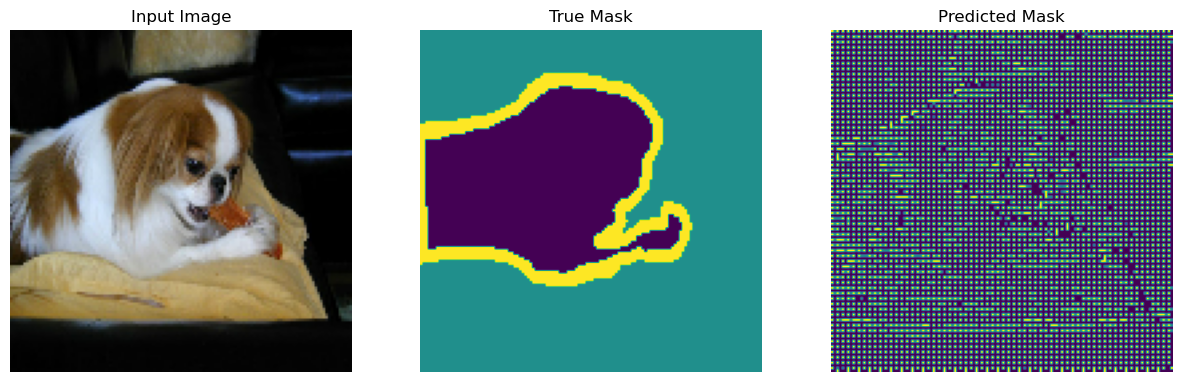

In [6]:
# Not trained example
show_predictions()

1/1 [==============================] - 0s 23ms/step


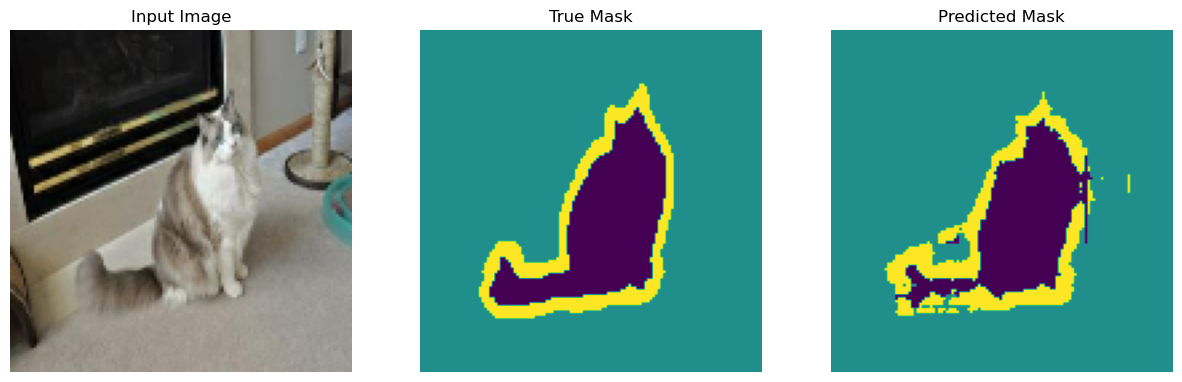


Sample Prediction after epoch 20

57/57 [==============================] - 68s 1s/step - loss: 0.1732 - accuracy: 0.9293 - val_loss: 0.2756 - val_accuracy: 0.9039


In [10]:
model_history = train()

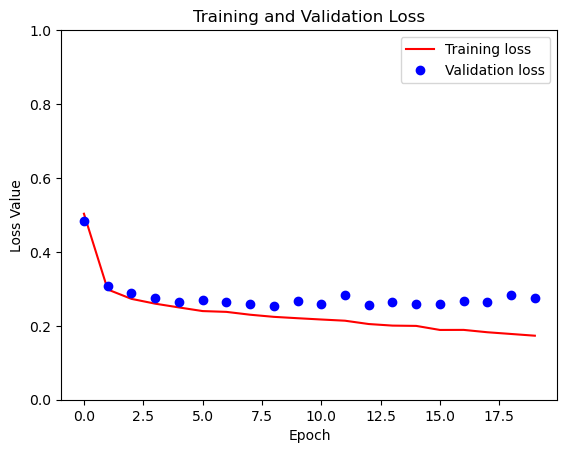

In [12]:
visualize_loss(model_history)

## Inference.py

In [11]:
import os
from PIL import Image
import numpy as np

def make_predictions(test_dataset, output_dir='../Result', num=5):
    os.makedirs(output_dir, exist_ok=True)

    for i, (image, mask) in enumerate(test_dataset.take(num)):
        pred_mask = model.predict(image)
        pred_mask = create_mask(pred_mask)

        # Save the images to the output directory
        save_path = os.path.join(output_dir, f"prediction_{i+1}")

        # Save the images to the output directory
        save_images(image[0], os.path.join(output_dir, f"input_image_{i+1}.png"))
        save_images(mask[0], os.path.join(output_dir, f"label_mask_{i+1}.png"))
        save_images(pred_mask, os.path.join(output_dir, f"predicted_mask_{i+1}.png"))

def save_images(image, save_path):
    # Convert the NumPy array to a PIL Image
    image_pil = Image.fromarray(np.uint8(image * 255.0))

    # Save the image
    image_pil.save(save_path)

In [12]:
make_predictions(test_batches)

2/2 [==============================] - 1s 233ms/step


TypeError: Cannot convert 255.0 to EagerTensor of dtype uint8

2/2 [==============================] - 1s 254ms/step


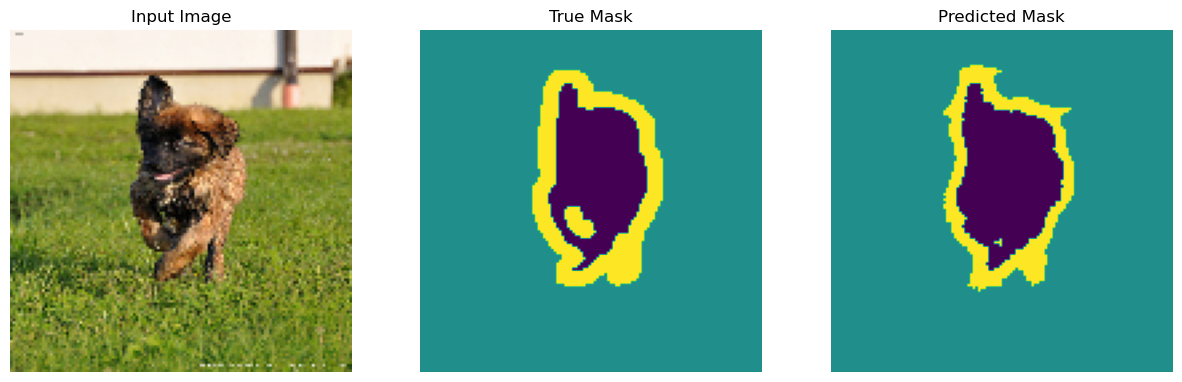

2/2 [==============================] - 1s 309ms/step


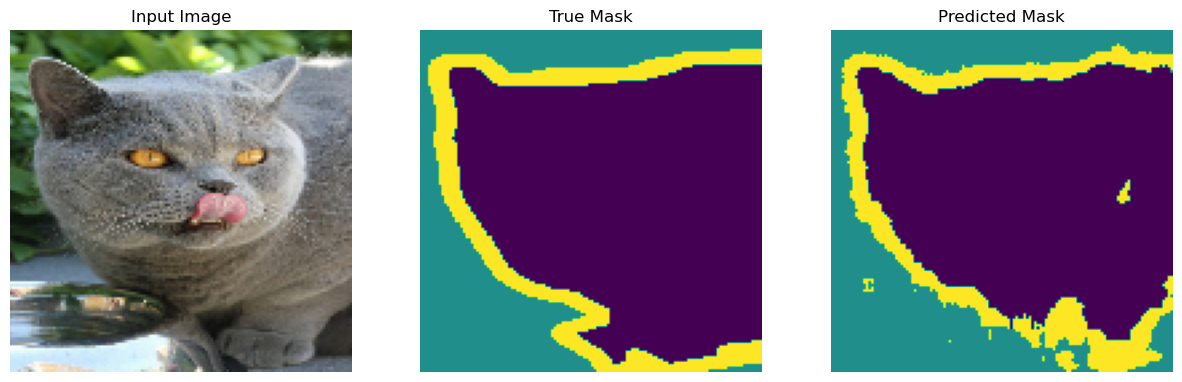

2/2 [==============================] - 1s 264ms/step


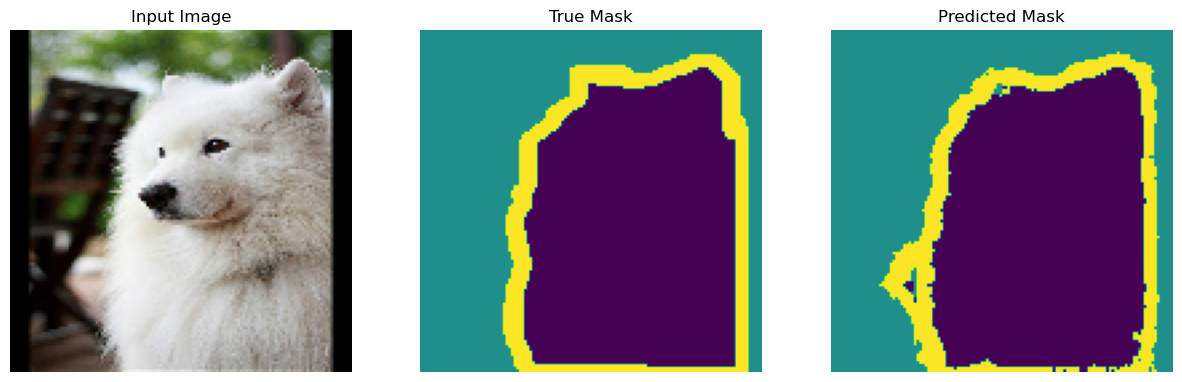

In [13]:
show_predictions(test_batches, 3)

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.

In [26]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20
57/57 [==============================] - 8s 111ms/step - loss: 0.2683 - accuracy: 0.9198
Epoch 2/20
57/57 [==============================] - 6s 111ms/step - loss: 0.2627 - accuracy: 0.9209
Epoch 3/20
57/57 [==============================] - 6s 111ms/step - loss: 0.2513 - accuracy: 0.9235
Epoch 4/20
57/57 [==============================] - 6s 111ms/step - loss: 0.2373 - accuracy: 0.9271
Epoch 5/20
57/57 [==============================] - 6s 111ms/step - loss: 0.2276 - accuracy: 0.9294
Epoch 6/20
57/57 [==============================] - 6s 111ms/step - loss: 0.2236 - accuracy: 0.9303
Epoch 7/20
57/57 [==============================] - 6s 111ms/step - loss: 0.2200 - accuracy: 0.9314
Epoch 8/20
57/57 [==============================] - 6s 111ms/step - loss: 0.2140 - accuracy: 0.9330
Epoch 9/20
57/57 [==============================] - 6s 111ms/step - loss: 0.2003 - accuracy: 0.9364
Epoch 10/20
57/57 [==============================] - 6s 110ms/step - loss: 0.1956 - accuracy: 0.9380

So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [27]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

Now, you can train a model on this weighted dataset: